In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.metrics import r2_score

from gradient_growing_trees.tree import GradientGrowingTreeRegressor
from gradient_growing_trees.tree_nn import TreeNN

Here is an example of the implementation of a simple composition of a neural network and gradient decision trees:

- the neural network consists of a softmax layer and one linear layer;
- it is implemented by histogram-like approach: target range is splitted into `embedding_size` intervals, and the trees estimate probabilities (to be more precise, logits) of that target variable belongs to each of the intervals.

The implementation using the Gradient Growing Trees and base `TreeNN` class is straightforward

In [2]:
class GumbelSoftmaxLayer(torch.nn.Module):
    def __init__(self, dim: int, tau=1.0, hard=False):
        super().__init__()
        self.dim = dim
        self.tau = tau
        self.hard = hard

    def forward(self, logits):
        return torch.nn.functional.gumbel_softmax(logits, dim=self.dim, tau=self.tau, hard=self.hard)


class BinRegressionTreeNN(TreeNN):
    def __post_init__(self):
        self.history = defaultdict(list)
        self.enable_postiter_nn = False
        self.nn_lr = 1.e-4
        self.nn_steps = 1
        self.random_state = 1
        self.sampling = False
        torch.manual_seed(self.random_state)

    def set_embedding_size(self, embedding_size: int):
        self.embedding_size = embedding_size
        return self

    def set_nn_lr(self, nn_lr: float):
        self.nn_lr = nn_lr
        return self

    def set_nn_steps(self, nn_steps: int):
        self.nn_steps = nn_steps
        return self

    def _postiter_nn(self, X_torch, y_torch, cumulative_predictions,
                     eval_X_nn=None,
                     eval_y=None,
                     eval_cumulative_predictions=None):
        if not self.enable_postiter_nn:
            return
        with torch.inference_mode():
            preds = self._predict_nn(X_torch, cumulative_predictions)
            self.history['loss/train'].append(
                self.__loss_fn(y_torch, preds).item()
            )
            self.history['r2/train'].append(
                r2_score(y_torch.numpy(), preds.numpy())
            )
            if eval_cumulative_predictions is not None:
                eval_preds = self._predict_nn(eval_X_nn, eval_cumulative_predictions)
                self.history['loss/val'].append(
                    self.__loss_fn(eval_y, eval_preds).item()
                )
                self.history['r2/val'].append(
                    r2_score(eval_y.numpy(), eval_preds.numpy())
                )

    def _pretrain_nn(self, X_nn_torch, y_torch):
        self.n_outputs_ = y_torch.shape[1]
        self.nn_ = torch.nn.Sequential(
            (
                torch.nn.Softmax(dim=1)
                if not self.sampling else
                GumbelSoftmaxLayer(dim=1, hard=True, tau=1)
            ),
            torch.nn.Linear(self.embedding_size, self.n_outputs_),
        ).to(torch.float64)
        self.optim_ = torch.optim.AdamW(self.nn_.parameters(), lr=self.nn_lr)
        mins, _ = y_torch.min(dim=0)
        maxs, _ = y_torch.max(dim=0)
        self.nn_[1].weight.data[:] = torch.stack([
            torch.linspace(mins[i], maxs[i], self.embedding_size)
            for i in range(len(mins))
        ], dim=0)
        self.nn_[1].bias.data[:] = y_torch.mean(dim=0) - self.nn_[1].weight.data.mean(dim=1)

    def _predict_nn(self, cur_X_torch, cur_trees_predictions_torch):
        return self.nn_(cur_trees_predictions_torch)

    def __loss_fn(self, cur_y_torch, nn_preds):
        return (cur_y_torch - nn_preds).pow(2).sum()

    def _post_update_nn(self, X_nn_torch, y_torch, sample_ids_torch, cumulative_predictions):
        for _ in range(self.nn_steps):
            self.optim_.zero_grad()
            nn_preds = self._predict_nn(X_nn_torch, cumulative_predictions)
            loss = self.__loss_fn(y_torch, nn_preds)
            loss.backward()
            self.optim_.step()

    def _calc_sample_grads(self, cur_X_torch, cur_y_torch,
                           cur_trees_predictions_torch,
                           cur_sample_predictions):
        nn_preds = self._predict_nn(cur_X_torch, cur_trees_predictions_torch)
        loss = self.__loss_fn(cur_y_torch, nn_preds)
        grads, = torch.autograd.grad(loss, cur_sample_predictions)
        return grads


Lets try it on a simple example

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_friedman3
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
X, y = make_friedman3(n_samples=400, noise=0.2, random_state=12345)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

In [5]:
params = dict(
    lam_2=0.1,
    lr=1.0,
    max_depth=3,
    n_estimators=100,
    splitter='best',
    n_update_iterations=1,
    embedding_size=20,
    nn_lr=1.e-4,
)
brt = BinRegressionTreeNN(
    base_estimator=GradientGrowingTreeRegressor(
        lam_2=params['lam_2'],
        lr=params['lr'],
        splitter=params['splitter'],
        max_depth=params['max_depth'],
        random_state=1,
    ),
    n_estimators=params['n_estimators'],
    lam_2=params['lam_2'],
    lr=params['lr'],
    tree_loss_on_sample_ids=True,
    n_update_iterations=params['n_update_iterations'],
).set_embedding_size(params['embedding_size']).set_nn_lr(params['nn_lr'])
brt.enable_postiter_nn = True
brt.fit(X_train, y_train.reshape((-1, 1)), eval_XyXnn=(X_test, y_test.reshape((-1, 1))))

BinRegressionTreeNN(base_estimator=GradientGrowingTreeRegressor(max_depth=3,
                                                                random_state=1),
                    embedding_size=20, n_estimators=100)

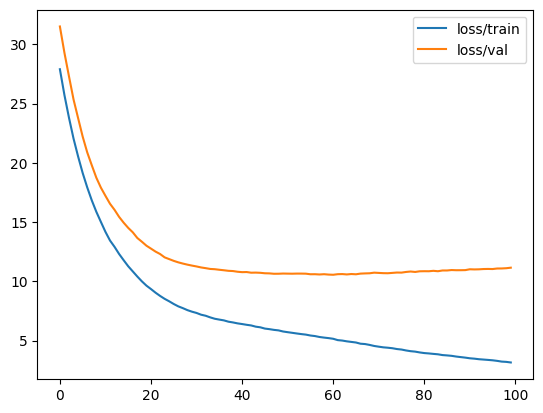

In [6]:
for k, v in brt.history.items():
    if 'loss/' in k:
        plt.plot(v, label=k)
plt.legend()

Lets also train some baseline model

In [7]:
gbm = GradientBoostingRegressor(n_estimators=params['n_estimators'], max_depth=params['max_depth'], random_state=1)
gbm.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

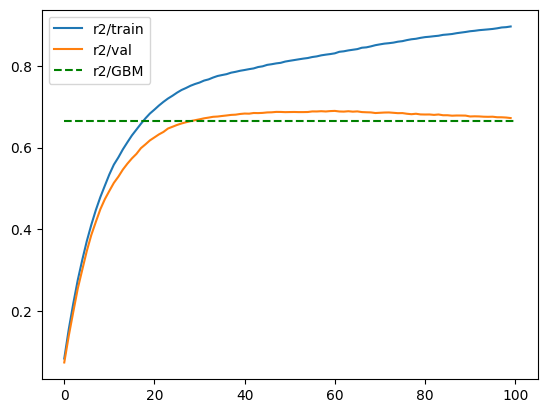

In [8]:
for k, v in brt.history.items():
    if 'r2/' in k:
        plt.plot(v, label=k)
plt.hlines(
    r2_score(y_test, gbm.predict(X_test)),
    0, len(next(iter(brt.history.values()))),
    colors='g',
    linestyles='dashed',
    label='r2/GBM',
)
plt.legend()